In [44]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from tqdm import tqdm

device = "cpu" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [45]:
#Loading model
import sys
import os
import torch
# Get the current script's directory
current_directory = os.getcwd()
print(current_directory)
library_directory = os.path.abspath(os.path.join(current_directory, 'torchVersion', 'BLIP'))
sys.path.append(library_directory)
from models.blip_vqa import blip_vqa

#model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_vqa.pth'

image_size = 480
model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model = model.to(device)
print(model)

e:\10mociclo\FoundationModels\Multiple-choice-VQA\FineTuningBLIP\testing
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_vqa.pth
BLIP_VQA(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
 

In [46]:
#Freezing all layers except MLP
number_of_last_trainable_layers = 3
N_BLIP = 11

def containsLastLayers(name):
    val = False
    for layer in list(range(N_BLIP-number_of_last_trainable_layers,N_BLIP+1)):
        if str(layer) in name:
            val = True
            break
    return val

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Keeping Visual encoder MLPs
for name, param in model.visual_encoder.named_parameters():
    if "mlp" in name and containsLastLayers(name):
        param.requires_grad = True

#Keeping FFNN from Image-grounded text encoder
for name, param in model.text_encoder.named_parameters():
    if "attention" not in name and "crossattention" not in name and "embeddings" not in name and containsLastLayers(name):
        param.requires_grad = True

#Keeping FFNN from Answer decoder
for name, param in model.text_encoder.named_parameters():
    if "attention" not in name and "crossattention" not in name and "embeddings" not in name and containsLastLayers(name):
        param.requires_grad = True

**Dataset**

In [47]:
import sys
sys.path.append('../')  # Adjust the path accordingly
from VQA_Dataset_BLIP import VQA_Dataset_preloaded_TorchVersion

dataset = VQA_Dataset_preloaded_TorchVersion(device)
#dataset.compute_store(model.tokenizer, length=20, fileName="embeddingsBLIPWithMultipleChoiceImageSize480Length20_20_TorchVersion.h5")

In [48]:
dataset.load(fileName="embeddingsBLIPWithMultipleChoiceImageSize480Length20_4k_TorchVersion.h5")

**Test-train split**

In [49]:
def custom_collate_fn(batch):
    # 'batch' is a list of samples, each being a dictionary
    return batch
# def custom_collate_fn(batch):
#     # 'batch' is a list of samples, each being a dictionary
#     new_batch ={}
#     for element in batch:
#         imgs_element = element["imgs"]
#         questions_input_ids_element = element["questions"]["input_ids"]
#         questions_attention_element = element["questions"]["attention_mask"]

#         multiple_answers_input_ids_element = element["multiple_answers"]["input_ids"]
#         multiple_answers_attention_element = element["multiple_answers"]["attention_mask"]

#         correct_answers_input_ids_element = element["correct_answers"]["input_ids"]
#         correct_answers_attention_element = element["correct_answers"]["attention_mask"]
        
        
#     return batch

In [50]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.7)
val_size = int(len(dataset)*0.2)
test_size = int(len(dataset))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)

batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

Train size:  2800
Test size:  400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


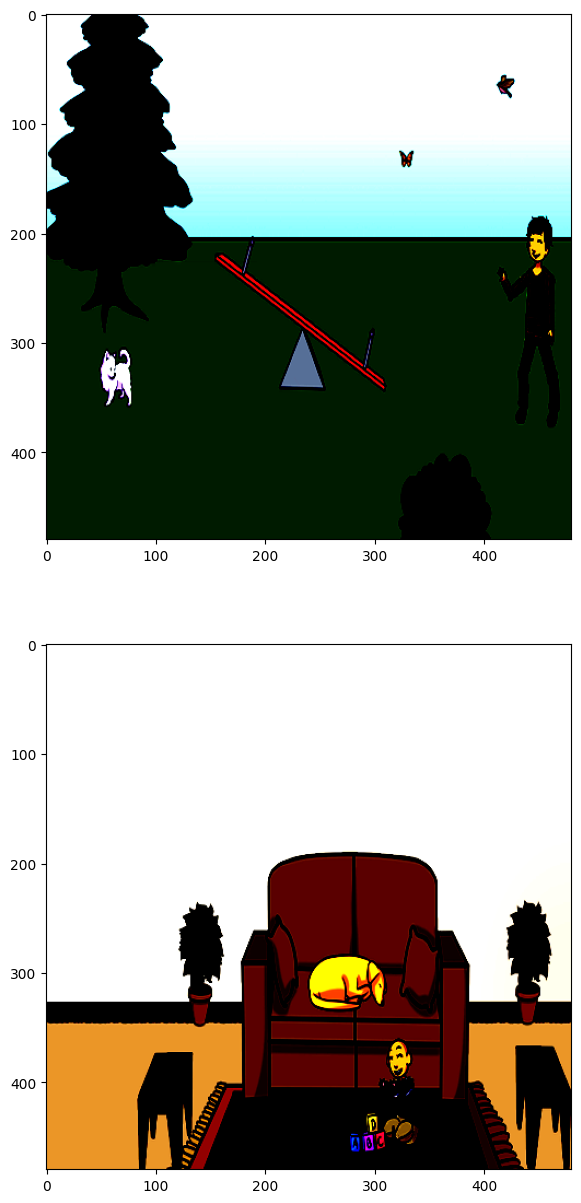

In [51]:
#Checking data
fig=plt.figure(0, (28, 15))
for element in train_dataloader:
    for i in range(batch_size):
        ax = fig.add_subplot(2,int(batch_size/2),i+1)
        #multiple_answers = np.array(element[2]).T[i]
        ax.imshow(np.transpose(element[i]["imgs"].squeeze(0).cpu(), (1, 2, 0))) #Converting to matplotlib format
        #ax.set_title("Question: "+str(element[1][i])+"\nMC Answers: "+str(multiple_answers)+"\nAnswer: "+str(element[3][i]), fontsize=9)
    break

**Evaluate using generate(w/o considering MC answers as input)**

In [52]:
import tqdm
#Evaluating raw model
def eval(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for element in pbar:
            for i in range(batch_size):     
                question = element[i]["questions"]
                img = element[i]["imgs"]
                correct_answer = element[i]["correct_answers"]
                        
                with torch.no_grad():
                    pred = model(img, question, train=False, inference='generate')
                    
                    predicted_answer = model.tokenizer(pred, padding='max_length', truncation=True, max_length=20,return_tensors="pt").to(device)["input_ids"][0]
                    predicted_answer[0] = 30523
                    correct_answer = correct_answer["input_ids"][0]
                    #print(f"Predicted: {predicted_answer}, Correct: {correct_answer}")  
                    correct += int(np.array_equal(correct_answer.detach().cpu().numpy(), predicted_answer.detach().cpu().numpy()))
    correct /= size
    return 100*correct
#eval(val_dataloader, model) #53.125% with 4k images(0.2) (using generate and model_base_vqa_capfilt_large)
#54.625% with 4k images(0.2) (using generate and model_base_vqa)

**Evaluate using rank**

In [53]:
import tqdm
#Evaluating raw model
def eval(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for element in pbar:
            for i in range(batch_size):     
                question = element[i]["questions"]
                img = element[i]["imgs"]
                multiple_answers = element[i]["multiple_answers"]
                correct_answer = element[i]["correct_answers"]
                        
                with torch.no_grad():
                    idx = model(img, question, answer = multiple_answers, train=False, inference='rank_compressed', k_test=18).item()
                    predicted_answer = multiple_answers["input_ids"][idx]
                    predicted_answer[0] = 30523
                    correct_answer = correct_answer["input_ids"][0]
                    #print(f"Predicted: {predicted_answer}, Correct: {correct_answer}")  
                    correct += int(np.array_equal(correct_answer.detach().cpu().numpy(), predicted_answer.detach().cpu().numpy()))
    correct /= size
    return 100*correct
#eval(val_dataloader, model) #63.5% with 4k images (using rank and model_base_vqa_capfilt_large)
#63.875% with 4k images(0.2) (using rank and model_base_vqa_capfilt_large)

**Fine tuning**

In [54]:
from torch.utils.tensorboard import SummaryWriter
import os 

#Tensorboard
currentModelIteration = "5e-5_4k"
folder_path = os.path.join("runs", "trainingsBLIP_TorchVersion", currentModelIteration)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

writer = SummaryWriter(folder_path)

In [55]:
def train(dataloader, vqa_model, optimizer, clip_value, epoch):
    size = len(dataloader.dataset)
    vqa_model.train()
    train_cost_acum = 0.0

    for batch_i, batch in enumerate(dataloader):    
        for i in range(batch_size):     
            question = batch[i]["questions"]
            img = batch[i]["imgs"]
            correct_answer = batch[i]["correct_answers"]

            optimizer.zero_grad()  
            loss = model(img, question, n=[1], answer = correct_answer, train=True, weights=torch.tensor([1]).to(device))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(vqa_model.parameters(), max_norm=clip_value, error_if_nonfinite=True)
            optimizer.step()
            train_cost_acum += loss
        
        #Ploting results
        
        if batch_i % 40 == 1:
            writer.add_scalar('Loss/training', float(train_cost_acum)/batch_i, epoch * size + batch_i)
            #writer.add_scalar('Accuracy/training', float(train_correct_num)/train_total, epoch * size + batch_i)
            loss, current = loss.item(), batch_i*batch_size
            print("loss: ", loss, current, size)

In [56]:
# #Batch version
# def train(dataloader, vqa_model, optimizer, clip_value, epoch):
#     size = len(dataloader.dataset)
#     vqa_model.train()
#     train_cost_acum = 0.0

#     for batch_i, batch in enumerate(dataloader):    
          
#         question = batch["questions"]
#         question["input_ids"] = question["input_ids"].squeeze(1)
#         question["attention_mask"] = question["attention_mask"].squeeze(1)

#         img = batch["imgs"].squeeze(1)

#         correct_answer = batch["correct_answers"]
#         correct_answer["input_ids"] = correct_answer["input_ids"].squeeze(1)
#         correct_answer["attention_mask"] = correct_answer["attention_mask"].squeeze(1)

#         optimizer.zero_grad()  
#         loss = model(img, question, n=[1], answer = correct_answer, train=True, weights=torch.tensor([1]).to(device))

#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(vqa_model.parameters(), max_norm=clip_value, error_if_nonfinite=True)
#         optimizer.step()
#         train_cost_acum += loss
        
#         #Ploting results
        
#         if batch_i % 40 == 1:
#             writer.add_scalar('Loss/training', float(train_cost_acum)/batch_i, epoch * size + batch_i)
#             #writer.add_scalar('Accuracy/training', float(train_correct_num)/train_total, epoch * size + batch_i)
#             loss, current = loss.item(), batch_i*batch_size
#             print("loss: ", loss, current, size)

In [57]:
def eval(dataloader, model, epoch):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for element in pbar:
            for i in range(batch_size):     
                question = element[i]["questions"]
                img = element[i]["imgs"]
                multiple_answers = element[i]["multiple_answers"]
                correct_answer = element[i]["correct_answers"]
                        
                with torch.no_grad():
                    idx = model(img, question, answer = multiple_answers, train=False, inference='rank_compressed', k_test=18).item()
                    predicted_answer = multiple_answers["input_ids"][idx]
                    predicted_answer[0] = 30523
                    correct_answer = correct_answer["input_ids"][0]
                    #print(f"Predicted: {predicted_answer}, Correct: {correct_answer}")  
                    correct += int(np.array_equal(correct_answer.detach().cpu().numpy(), predicted_answer.detach().cpu().numpy()))
    correct /= size

    #Ploting results
    writer.add_scalar('Accuracy/test', correct*100, epoch)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")
    return 100*correct

In [58]:
# #Batch version
# def eval(dataloader, model, epoch):
#     size = len(dataloader.dataset)
#     model.eval()
#     correct = 0
#     pbar = tqdm.tqdm(dataloader)
#     with torch.no_grad():
#         for element in pbar:
#             for i in range(batch_size):
#                 img = element["imgs"][i]
#                 question = {key: value[i] for key, value in element["questions"].items()}
#                 multiple_answers = {key: value[i] for key, value in element["multiple_answers"].items()}
#                 correct_answer = {key: value[i] for key, value in element["correct_answers"].items()}

#                 with torch.no_grad():
#                     idx = model(img, question, answer = multiple_answers, train=False, inference='rank_compressed', k_test=18).item()
#                     predicted_answer = multiple_answers["input_ids"][idx]
#                     predicted_answer[0] = 30523
#                     correct_answer = correct_answer["input_ids"][0]
#                     #print(f"Predicted: {predicted_answer}, Correct: {correct_answer}")
#                     correct += int(np.array_equal(correct_answer.detach().cpu().numpy(), predicted_answer.detach().cpu().numpy()))
#     correct /= size

#     #Ploting results
#     writer.add_scalar('Accuracy/test', correct*100, epoch)
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")
#     return 100*correct

In [59]:
#Hyperparameters and optim
import torch
clip_value = 1.0
learning_rate = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

torch.cuda.empty_cache() 

In [60]:
#Early stopping parameters
n_epochs = 50
early_stop_threshhold = 5
best_accuracy = -1
best_epoch = -1

def checkpoint(model, filename):
    folder_path = os.path.join("runs", "best_model", currentModelIteration)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    torch.save(model.state_dict(), os.path.join(folder_path, filename))
    
def resume(model, filename):
    model.load_state_dict(torch.load(os.path.join("runs", "checkpoint_SolvingCropping", filename)))

In [61]:
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, optimizer, clip_value, epoch)
    acc = eval(train_dataloader, model, epoch)
    if acc>best_accuracy:
        best_accuracy = acc
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif (epoch-best_epoch) > early_stop_threshhold:
        print("--Early stopped training--")
        break

Epoch 1
-------------------------------
loss:  4.772850036621094 2 2800


KeyboardInterrupt: 